In [26]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np
import random
from typing import Tuple, List

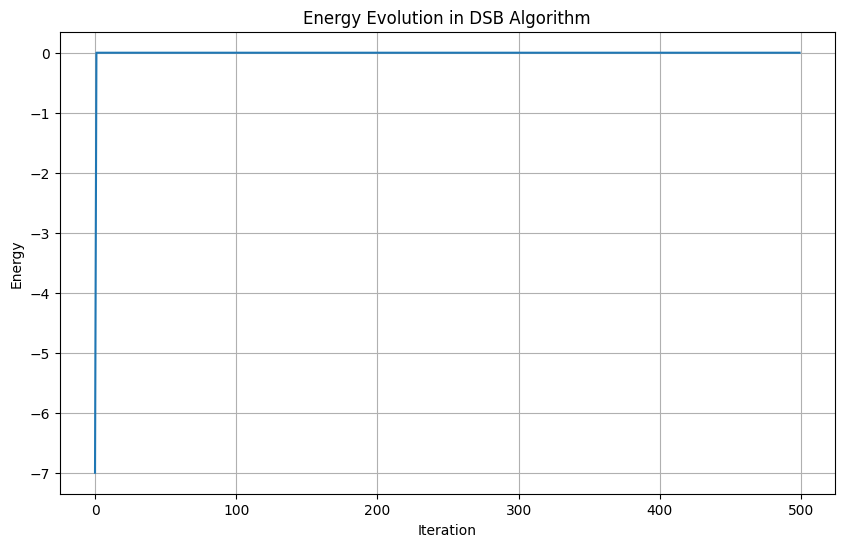

Partition: [-1, -1, -1, -1, -1, -1, -1]
Max Cut value: 0.0


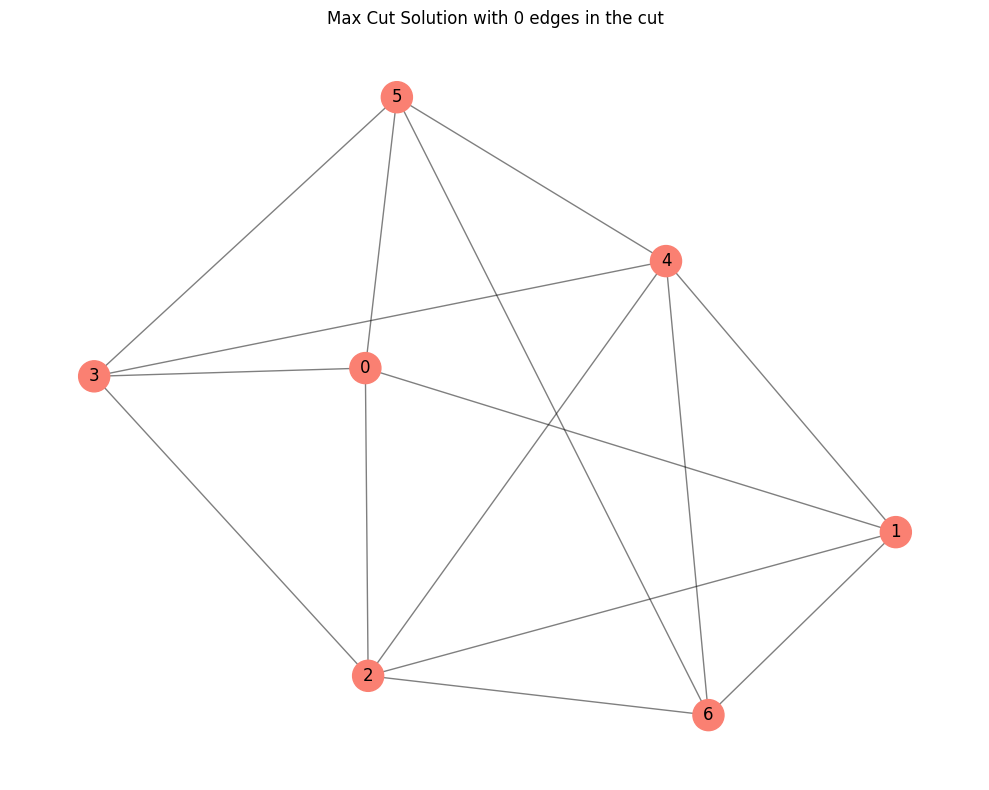

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional


def solve_max_cut_with_dsb(
    adjacency_matrix: np.ndarray,
    num_iterations: int = 1000,
    alpha: float = 0.5,
    beta: float = 0.9,
    initial_state: Optional[np.ndarray] = None,
    plot_energy: bool = False
) -> Tuple[List[int], float, List[float]]:
    """
    Solve the Max Cut problem using Discrete Simulated Bifurcation algorithm.
    
    The Max Cut problem aims to partition graph vertices into two sets such that
    the number of edges between the sets is maximized.
    
    Args:
        adjacency_matrix: A square numpy array representing the graph's adjacency matrix
        num_iterations: Number of iterations for the algorithm
        alpha: Control parameter for field updates (typically 0.1 to 0.9)
        beta: Momentum decay parameter (typically 0.5 to 0.95)
        initial_state: Optional initial spin state, randomly initialized if None
        plot_energy: Whether to plot the energy history
        
    Returns:
        spins: Final configuration of spins (+1 or -1 for each node)
        cut_value: The value of the cut (number of edges between the two partitions)
        energy_history: List of energy values at each iteration
    """
    n = adjacency_matrix.shape[0]
    assert adjacency_matrix.shape == (n, n), "Adjacency matrix must be square"
    
    # Initialize spins randomly if not provided
    if initial_state is None:
        x = np.random.uniform(-1.0, 1.0, n)  # Continuous values for DSB
    else:
        x = initial_state.copy()
    
    # Initialize momentum with zeros
    p = np.zeros(n)
    
    # Convert adjacency matrix to Ising model coupling matrix
    # In the Ising model, we want to minimize -∑J_ij*s_i*s_j
    # For Max Cut, we want to maximize ∑J_ij*(1-s_i*s_j)/2
    # These are equivalent when J_ij in Ising = -A_ij in Max Cut
    J = -adjacency_matrix
    
    # Track energy history for visualization
    energy_history = []
    
    # DSB iteration loop
    for t in range(num_iterations):
        # Calculate effective field for each spin
        h = np.zeros(n)
        for i in range(n):
            for j in range(n):
                h[i] += J[i, j] * np.sign(x[j])
        
        # Update momentum with a field term
        p = beta * p - alpha * h
        
        # Update position (continuous spin values)
        x = x + p
        
        # Calculate and record energy
        energy = calculate_energy(np.sign(x), adjacency_matrix)
        energy_history.append(energy)
    
    # Final spin configuration
    final_spins = np.sign(x).astype(int).tolist()
    
    # Calculate the cut value
    cut_value = calculate_cut_value(final_spins, adjacency_matrix)
    
    # Plot energy evolution if requested
    if plot_energy:
        plt.figure(figsize=(10, 6))
        plt.plot(energy_history)
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.title('Energy Evolution in DSB Algorithm')
        plt.grid(True)
        plt.show()
    
    return final_spins, cut_value, energy_history


def calculate_energy(spins: np.ndarray, adjacency_matrix: np.ndarray) -> float:
    """
    Calculate the energy of a spin configuration for the Max Cut problem.
    
    For Max Cut, we want to maximize ∑A_ij*(1-s_i*s_j)/2,
    which is equivalent to minimizing -∑A_ij*(1-s_i*s_j)/2
    
    Args:
        spins: Array of spin values (+1 or -1)
        adjacency_matrix: Adjacency matrix of the graph
        
    Returns:
        Energy value (lower is better in this formulation)
    """
    n = len(spins)
    energy = 0.0
    
    for i in range(n):
        for j in range(i+1, n):  # Avoid double counting edges
            if adjacency_matrix[i, j] > 0:  # If there's an edge
                energy -= adjacency_matrix[i, j] * (1 - spins[i] * spins[j]) / 2
                
    return energy


def calculate_cut_value(spins: List[int], adjacency_matrix: np.ndarray) -> float:
    """
    Calculate the cut value for a given partition.
    
    The cut value is the sum of weights of edges connecting vertices
    in different partitions.
    
    Args:
        spins: List of spin values (+1 or -1) representing the partition
        adjacency_matrix: Adjacency matrix of the graph
        
    Returns:
        Cut value (higher is better)
    """
    n = len(spins)
    cut_value = 0.0
    
    for i in range(n):
        for j in range(i+1, n):  # Avoid double counting edges
            if adjacency_matrix[i, j] > 0 and spins[i] != spins[j]:
                cut_value += adjacency_matrix[i, j]
                
    return cut_value


def visualize_max_cut(adjacency_matrix: np.ndarray, partition: List[int]) -> None:
    """
    Visualize the graph and the Max Cut solution.
    
    Args:
        adjacency_matrix: Adjacency matrix of the graph
        partition: List of +1/-1 values indicating the partition
    """
    try:
        import networkx as nx
        
        # Create a graph from the adjacency matrix
        G = nx.from_numpy_array(adjacency_matrix)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G, seed=42)
        
        # Convert +1/-1 partition to node colors
        node_colors = ['skyblue' if s > 0 else 'salmon' for s in partition]
        
        # Count edges in the cut
        cut_edges = [(i, j) for i in range(len(partition)) for j in range(i+1, len(partition))
                    if adjacency_matrix[i, j] > 0 and partition[i] != partition[j]]
        
        # Draw the graph
        plt.figure(figsize=(10, 8))
        
        # Draw nodes with partition colors
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
        
        # Draw edges not in the cut
        non_cut_edges = [(i, j) for i, j in G.edges() if (i, j) not in cut_edges and (j, i) not in cut_edges]
        nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, width=1.0, alpha=0.5)
        
        # Highlight cut edges
        nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2.0, alpha=1.0, 
                              edge_color='red', style='dashed')
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos)
        
        plt.title(f"Max Cut Solution with {len(cut_edges)} edges in the cut")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("NetworkX is required for visualization. Install it with: pip install networkx")


# Example usage
if __name__ == "__main__":
    # Create a sample graph as an adjacency matrix
    # For a simple example, we'll use a 5-node graph
    adj_matrix = np.array([
        [0, 1, 2, 1, 0, 3, 0],
        [1, 0, 1, 0, 2, 0, 3],
        [2, 1, 0, 3, 1, 0, 2],
        [1, 0, 3, 0, 1, 2, 0],
        [0, 2, 1, 1, 0, 3, 1],
        [3, 0, 0, 2, 3, 0, 1],
        [0, 3, 2, 0, 1, 1, 0]
    ])
    
    # Solve the Max Cut problem
    solution, cut_value, energy_history = solve_max_cut_with_dsb(
        adj_matrix, 
        num_iterations=500,
        alpha=0.5,
        beta=0.9,
        plot_energy=True
    )
    
    print(f"Partition: {solution}")
    print(f"Max Cut value: {cut_value}")
    
    # Visualize the solution
    visualize_max_cut(adj_matrix, solution)